# Hospital Readmission Dataset Analysis
This notebook presents a comprehensive workflow for analyzing hospital readmission data. It includes data preprocessing, feature selection, and model development, with a focus on explainable AI techniques applied to both tree-based models and neural networks.

# Setup and Imports

In [1]:
# Standard Library
import time
from collections import defaultdict

# Data Manipulation and Analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Analysis
from scipy.stats import (
    chi2_contingency, 
    pointbiserialr, 
    spearmanr, 
    pearsonr, 
    ttest_ind
)
import dcor

# Machine Learning
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    roc_auc_score
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

# Deep Learning (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.ops import sigmoid_focal_loss

# SHAP (Explainable AI)
import shap

# Data analysis

In [2]:
# Load the dataset
data = pd.read_csv("train.csv")
# Changing all trues to 1 and falses to 0
data = data.replace({True: 1, False: 0})
# Prepare features and target
X = data.drop('readmitted', axis=1)
y = data['readmitted']
# PRINT STATEMENTS FOR INITIAL VIEW
print(data.info())
print(data.head())
print(data.isnull().sum().to_string())
print(data.describe())
# First 8 columns are ints, remaining are boolean values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 65 columns):
 #   Column                                    Non-Null Count  Dtype
---  ------                                    --------------  -----
 0   time_in_hospital                          25000 non-null  int64
 1   num_lab_procedures                        25000 non-null  int64
 2   num_procedures                            25000 non-null  int64
 3   num_medications                           25000 non-null  int64
 4   number_outpatient                         25000 non-null  int64
 5   number_emergency                          25000 non-null  int64
 6   number_inpatient                          25000 non-null  int64
 7   number_diagnoses                          25000 non-null  int64
 8   race_Caucasian                            25000 non-null  int64
 9   race_AfricanAmerican                      25000 non-null  int64
 10  gender_Female                             25000 non-null  

In [3]:
# Count rows where the last column ends with 1 or 0
num_rows_end_1 = data[data.iloc[:, -1] == 1].shape[0]
num_rows_end_0 = data[data.iloc[:, -1] == 0].shape[0]
print(f"Rows ending in 1: {num_rows_end_1}, Rows ending in 0: {num_rows_end_0}")

Rows ending in 1: 11410, Rows ending in 0: 13590


                   min    Q1 median    Q3  max  \
Feature                                          
time_in_hospital     1   2.0    4.0   6.0   14   
num_lab_procedures   1  31.0   44.0  57.0  126   
num_procedures       0   0.0    1.0   2.0    6   
num_medications      1  10.0   15.0  20.0   81   
number_outpatient    0   0.0    0.0   0.0   36   
number_emergency     0   0.0    0.0   0.0   64   
number_inpatient     0   0.0    0.0   1.0   21   
number_diagnoses     1   6.0    8.0   9.0   16   

                                                             outliers  
Feature                                                                
time_in_hospital    [14, 14, 13, 13, 13, 14, 14, 14, 14, 14, 13, 1...  
num_lab_procedures  [103, 106, 101, 108, 108, 97, 97, 97, 98, 106,...  
num_procedures      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...  
num_medications     [45, 48, 46, 48, 36, 39, 60, 58, 46, 42, 46, 3...  
number_outpatient   [1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, .

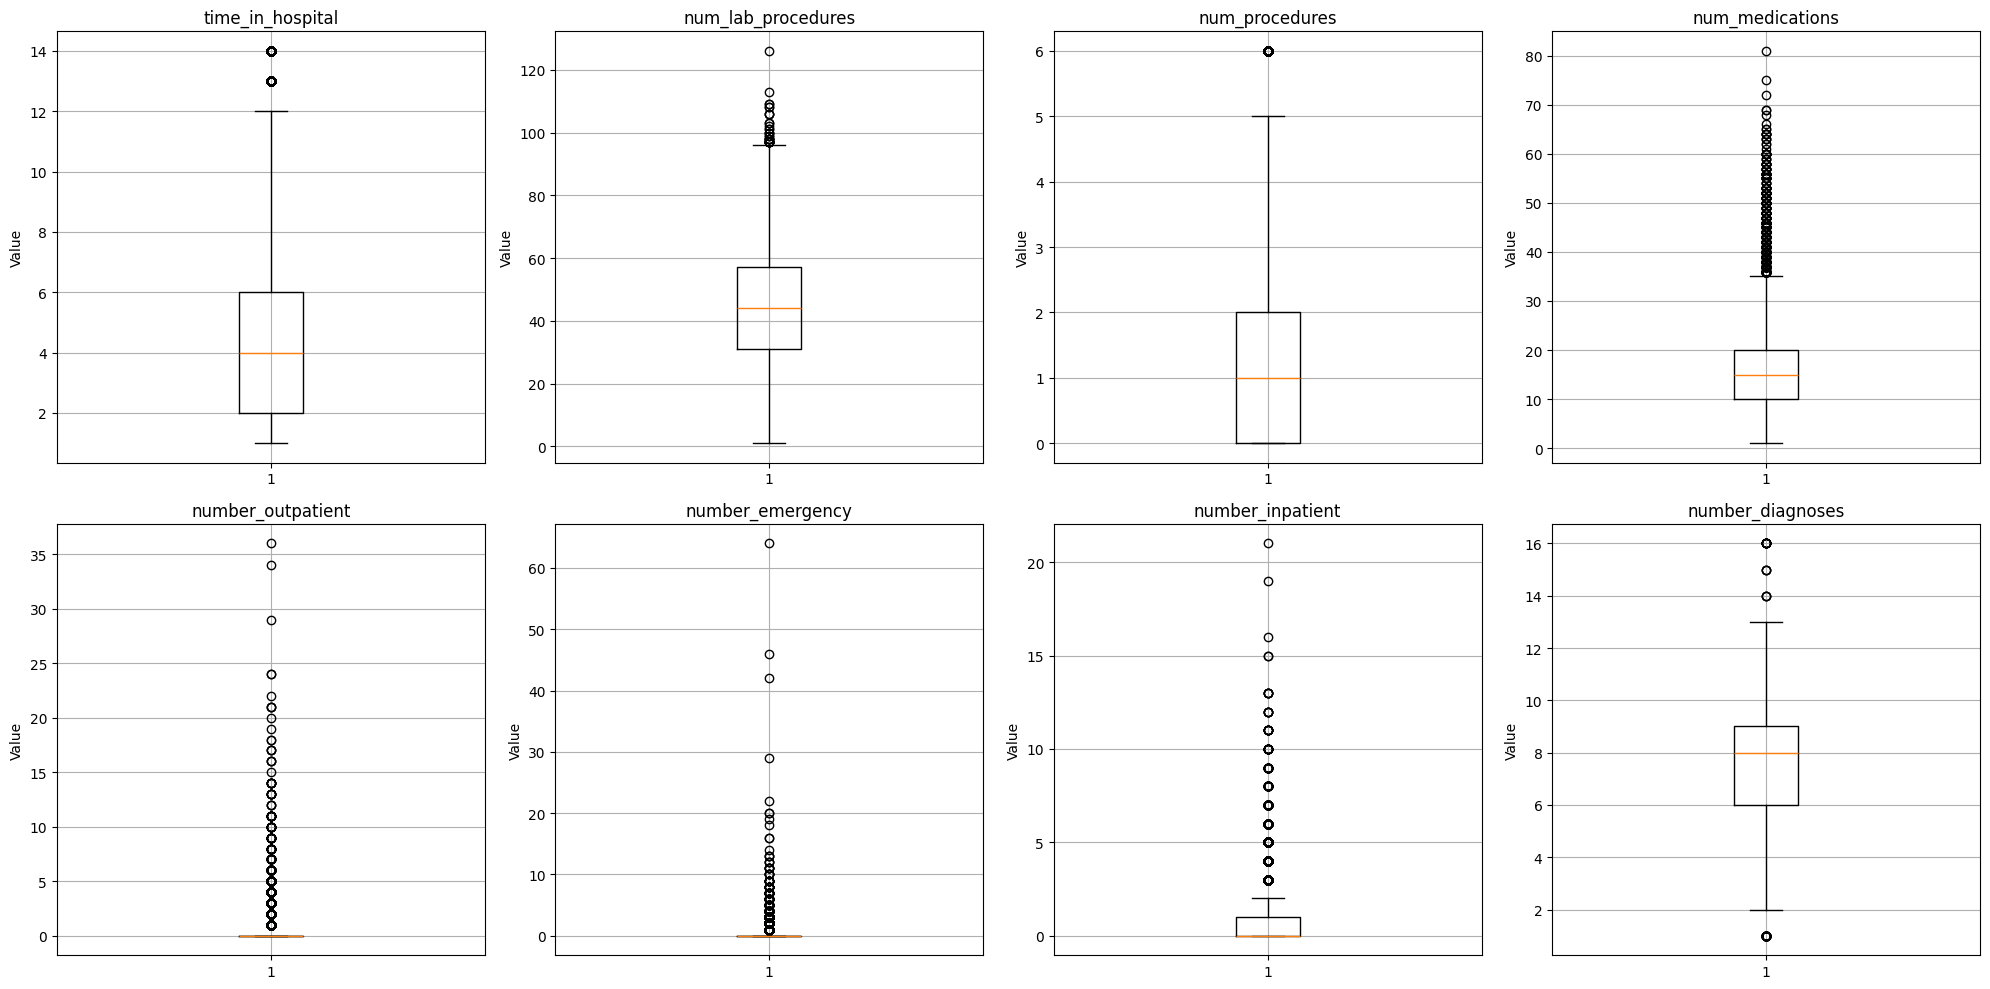

In [4]:
# Box and whisker plots for the first 8 features
# Calculate statistics for the first 8 metrics
boxplot_data = {}
min_before_outlier = []

for col in data.columns[:8]:  # Iterate over the first 8 columns
    col_data = data[col].dropna()  # Drop NaN values
    # Calculate Q1, Q3, and IQR
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define the outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find non-outlier values
    non_outliers = data[col][(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    min_before_outlier.append(non_outliers.max())
    stats = {
        'min': col_data.min(),
        'Q1': col_data.quantile(0.25),  # First quartile (25th percentile)
        'median': col_data.median(),  # Median (50th percentile)
        'Q3': col_data.quantile(0.75),  # Third quartile (75th percentile)
        'max': col_data.max(),
        'outliers': col_data[
            (col_data < col_data.quantile(0.25) - 1.5 * (col_data.quantile(0.75) - col_data.quantile(0.25))) |
            (col_data > col_data.quantile(0.75) + 1.5 * (col_data.quantile(0.75) - col_data.quantile(0.25)))
        ].tolist()  # Detect outliers
    }
    
    boxplot_data[col] = stats

# Convert to DataFrame for easier viewing
boxplot_df = pd.DataFrame(boxplot_data).T
boxplot_df.index.name = 'Feature'

# Display the statistics
print(boxplot_df)
print(min_before_outlier)

# # Optionally save to CSV
# boxplot_df.to_csv("boxplot_statistics.csv")

# Plot box-and-whisker plots for the first 8 metrics
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # Create a 2x4 grid of subplots
axs = axs.ravel()  # Flatten the array of subplots

for i, col in enumerate(data.columns[:8]):  # Iterate over the first 8 columns
    axs[i].boxplot(data[col].dropna())  # Create a box plot for each column, dropping NaN values
    axs[i].set_title(col)  # Set the title of the subplot to the column name
    axs[i].set_ylabel('Value')  # Set the Y-axis label
    axs[i].grid(True)  # Add a grid for better readability

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()  # Display the plots

In [5]:
# Checking for columns with 0 variance, basically useless columns

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Don't truncate horizontally
pd.set_option('display.max_colwidth', None)  # Don't truncate cell content

zero_variance_cols = data.columns[data.nunique() <= 1]
print(f"Columns with zero variance: {zero_variance_cols}")

Columns with zero variance: Index(['acetohexamide_No', 'examide_No', 'citoglipton_No',
       'metformin-rosiglitazone_No', 'metformin-pioglitazone_No'],
      dtype='object')


In [6]:
# Correlation between features and target

# Initialize a DataFrame to store results
feature_analysis = pd.DataFrame({'Feature': X.columns})

# Mutual Information
mi_scores = mutual_info_classif(X, y, random_state=42)
feature_analysis['Mutual Information'] = mi_scores

# Point-Biserial Correlation for integer features
point_biserial_scores = []

# Ensure to use original integer columns from `data`
integer_columns = [col for col in data.columns if data[col].dtype in ['int64', 'int32'] and col != 'readmitted']  # Exclude target

for col in X.columns:
    if col in integer_columns:  # Check if the column is in the list of integer columns
        correlation, _ = pointbiserialr(data[col], y)  # Use original data for calculation
        point_biserial_scores.append(correlation)
    else:
        point_biserial_scores.append(None)  # Append None for non-integer columns

# Add the Point-Biserial Correlation scores to the feature_analysis DataFrame
feature_analysis['Point-Biserial Correlation'] = point_biserial_scores

# Chi-Square test
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
chi2_scores, p_values = chi2(X_scaled, y)
feature_analysis['Chi-Square Score'] = chi2_scores
feature_analysis['Chi-Square p-value'] = p_values

# Random Forest Feature Importance
clf = RandomForestClassifier(random_state=42)
clf.fit(X, y)

feature_importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_analysis['Random Forest Importance'] = feature_importances.reindex(feature_analysis['Feature']).values

# Sort by Mutual Information (or any metric of choice)
feature_analysis.sort_values(by='Mutual Information', ascending=False, inplace=True)

# Extract and print the top features for each metric

# Number of top features to display
top_n = 20

# Mutual Information
print("\nTop Features by Mutual Information:")
top_mi = feature_analysis[['Feature', 'Mutual Information']].sort_values(by='Mutual Information', ascending=False).head(top_n)
for index, row in top_mi.iterrows():
    print(f"{row['Feature']}: {row['Mutual Information']:.4f}")

# Point-Biserial Correlation
print("\nTop Features by Point-Biserial Correlation:")
top_pb = feature_analysis[['Feature', 'Point-Biserial Correlation']].dropna().sort_values(by='Point-Biserial Correlation', ascending=False).head(top_n)
for index, row in top_pb.iterrows():
    print(f"{row['Feature']}: {row['Point-Biserial Correlation']:.4f}")

# Chi-Square Scores
print("\nTop Features by Chi-Square Score (with p-value):")
top_chi2 = feature_analysis[['Feature', 'Chi-Square Score', 'Chi-Square p-value']].sort_values(by='Chi-Square Score', ascending=False).head(top_n)
for index, row in top_chi2.iterrows():
    print(f"{row['Feature']}: Score = {row['Chi-Square Score']:.4f}, p-value = {row['Chi-Square p-value']:.4e}")

# Random Forest Feature Importance
print("\nTop Features by Random Forest Importance:")
top_rf = feature_analysis[['Feature', 'Random Forest Importance']].sort_values(by='Random Forest Importance', ascending=False).head(top_n)
for index, row in top_rf.iterrows():
    print(f"{row['Feature']}: {row['Random Forest Importance']:.4f}")

print(feature_analysis.columns)

c:\Users\TJ365\anaconda3\envs\BE400\lib\site-packages\scipy\stats\_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)



Top Features by Mutual Information:
number_inpatient: 0.0272
number_emergency: 0.0164
number_outpatient: 0.0114
number_diagnoses: 0.0109
max_glu_serum_None: 0.0094
diag_3_250: 0.0080
rosiglitazone_No: 0.0079
num_medications: 0.0079
glimepiride-pioglitazone_No: 0.0078
metformin_No: 0.0073
time_in_hospital: 0.0062
medical_specialty_?: 0.0059
medical_specialty_InternalMedicine: 0.0059
medical_specialty_Family/GeneralPractice: 0.0059
race_Caucasian: 0.0058
diag_3_401: 0.0056
glipizide-metformin_No: 0.0053
troglitazone_No: 0.0051
glyburide_No: 0.0050
gender_Female: 0.0049

Top Features by Point-Biserial Correlation:
number_inpatient: 0.2165
number_diagnoses: 0.1234
number_emergency: 0.1006
number_outpatient: 0.0871
diag_1_428: 0.0702
diabetesMed_Yes: 0.0599
time_in_hospital: 0.0576
num_medications: 0.0564
num_lab_procedures: 0.0401
medical_specialty_?: 0.0386
payer_code_MC: 0.0379
diag_2_428: 0.0362
metformin_No: 0.0312
medical_specialty_Emergency/Trauma: 0.0307
race_Caucasian: 0.0271
diag

# Data Preprocessing

In [7]:
# Removing outliers, capping them at outlier minimum value, normalizing all values to between 0-1

# The vector of thresholds
thresholds = [np.int64(12), np.int64(96), np.int64(5), np.int64(35), 
              np.int64(0), np.int64(0), np.int64(2), np.int64(13)]

# Step 1: Cap values larger than the thresholds
for i, col in enumerate(data.columns[:8]):  # Loop over the first 8 columns
    data[col] = np.where(data[col] > thresholds[i], thresholds[i] + 1, data[col])

# Step 2: Scale values in the first 8 columns to the range [0, 1]
scaler = MinMaxScaler()
data[data.columns[:8]] = scaler.fit_transform(data[data.columns[:8]])

In [8]:
# Removing columns which have 0 variance, little to no impact in SHAP analysis

# Columns to remove
columns_to_remove = [
    "tolbutamide_No",
    "miglitol_No",
    "citoglipton_No",
    "metformin-pioglitazone_No",
    "tolazamide_No",
    "chlorpropamide_No",
    "examide_No",
    "metformin-rosiglitazone_No",
    "acetohexamide_No"
]

data = data.drop(columns=columns_to_remove)


# Working with the Neural Networks

In [9]:
# Creating train loader and such

# Set random seed for reproducibility
random_state = 42

# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset Class for Neural Networks
class ReadmissionDataset(Dataset):
    def __init__(self, features, target):
        """
        Initialize the dataset with preprocessed features and target.
        """
        self.features = torch.tensor(features, dtype=torch.float32)
        self.target = torch.tensor(target, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]


target_column = "readmitted"
# Handle categorical variables
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
for col in categorical_columns:
    data[col] = LabelEncoder().fit_transform(data[col])

# Handle missing values
data = data.fillna(data.median())  # Replace missing values with median

# Balance the dataset (if imbalanced)
majority_class = data[data[target_column] == 0]
minority_class = data[data[target_column] == 1]
n_samples = min(len(majority_class), len(minority_class))

balanced_data = pd.concat([
    majority_class.sample(n=n_samples, random_state=random_state),
    minority_class.sample(n=n_samples, random_state=random_state)
]).sample(frac=1, random_state=random_state).reset_index(drop=True)

# Separate features and target
X = balanced_data.drop(columns=[target_column]).values
y = balanced_data[target_column].values

# Extract feature names
feature_names = balanced_data.drop(columns=[target_column]).columns.tolist()

# Split into train and test sets
rando = int(time.time())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rando)

# Normalize the features (standard scaling)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch datasets
train_dataset = ReadmissionDataset(X_train, y_train)
test_dataset = ReadmissionDataset(X_test, y_test)

# DataLoader initialization
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
feature_count = 64

# Example: Checking shapes from train_loader
for batch_features, batch_targets in train_loader:
    print("Train Batch Features Shape:", batch_features.shape)
    print("Train Batch Targets Shape:", batch_targets.shape)
    feature_count = batch_features.shape[1]
    break

# Set input size based on your dataset
input_size = feature_count  # Number of input features

Train Batch Features Shape: torch.Size([64, 55])
Train Batch Targets Shape: torch.Size([64])


In [10]:
# Define the neural network
class BinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # First fully connected layer
        self.fc2 = nn.Linear(128, 64)         # Second fully connected layer
        self.fc3 = nn.Linear(64, 1)           # Output layer
        self.relu = nn.ReLU()                 # Activation function
        self.dropout = nn.Dropout(0.5)        # Dropout for regularization

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # No activation here; we'll use BCEWithLogitsLoss
        return x
    
model = BinaryClassifier(input_size).to(device)

criterion = nn.BCEWithLogitsLoss()  # Combines sigmoid activation + binary cross-entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

In [11]:
# Running the model with early stopping and monte carlo

# Training the model with Early Stopping
def train_model_with_early_stopping(model, train_loader, test_loader, criterion, optimizer, num_epochs=50, patience=5):
    best_loss = float('inf')  # Initialize best loss as infinity
    patience_counter = 0      # Counter for early stopping
    best_model_state = None   # To store the best model's state

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for features, targets in train_loader:
            features, targets = features.to(device), targets.to(device)
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(features).squeeze()  # Forward pass
            loss = criterion(outputs, targets)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()

        # Compute training loss
        train_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for features, targets in test_loader:
                features, targets = features.to(device), targets.to(device)
                outputs = model(features).squeeze()
                loss = criterion(outputs, targets)  # Compute loss
                val_loss += loss.item()

        val_loss /= len(test_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Check for improvement in validation loss
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0  # Reset patience counter
            best_model_state = model.state_dict()  # Save the best model's state
        else:
            patience_counter += 1
            print(f"Patience counter: {patience_counter}/{patience}")

            # Early stopping
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    # Load the best model's state
    if best_model_state:
        model.load_state_dict(best_model_state)

# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    y_pred = []
    y_true = []
    y_scores = []
    with torch.no_grad():
        for features, targets in test_loader:
            features, targets = features.to(device), targets.to(device)
            outputs = model(features).squeeze()
            scores = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
            preds = torch.sigmoid(outputs) > 0.5  # Convert logits to binary predictions
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(targets.cpu().numpy())
            y_scores.extend(scores.cpu().numpy())

    # Compute evaluation metrics
    from sklearn.metrics import classification_report, accuracy_score
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    report = classification_report(y_true, y_pred, output_dict=True)

    # Compute and display ROC AUC score
    try:
        roc_auc = roc_auc_score(y_true, y_scores)
        print(f"ROC AUC: {roc_auc:.4f}")
    except ValueError:
        print("ROC AUC could not be computed (e.g., only one class present in y_true).")
    return report, roc_auc

def monteCarlo(runs, model, criterion, optimizer, num_epochs=50, patience=5):
    reports = []
    roc_scores = 0
    for i in range(runs):
        print("this is run " + str(i+1))
        # Randomly split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rando + i)

        # Normalize the features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Create DataLoaders
        train_dataset = ReadmissionDataset(X_train, y_train)
        test_dataset = ReadmissionDataset(X_test, y_test)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Initialize a fresh model and optimizer for each run
        model = BinaryClassifier(X_train.shape[1]).to(device)
        optimizer = optim.Adam(model.parameters())

        train_model_with_early_stopping(model, train_loader, test_loader, criterion, optimizer, num_epochs=num_epochs, patience=patience)
        report, roc_score = evaluate_model(model, test_loader)
        reports.append(report)
        roc_scores += roc_score
    # Aggregate metrics
    aggregated_metrics = defaultdict(lambda: defaultdict(list))  # For per-class and average metrics
    scalar_metrics = defaultdict(list)  # For scalar metrics like "accuracy"

    # Gather metrics for each class and overall averages
    for report in reports:
        for class_name, metrics in report.items():
            if isinstance(metrics, dict):  # For dictionary-based metrics (e.g., precision, recall, f1-score)
                for metric_name, value in metrics.items():
                    aggregated_metrics[class_name][metric_name].append(value)
            else:  # For scalar metrics (e.g., "accuracy")
                scalar_metrics[class_name].append(metrics)

    # Compute means for each metric
    mean_metrics = {}

    # Compute mean for dictionary-based metrics
    for class_name, metrics in aggregated_metrics.items():
        mean_metrics[class_name] = {metric: float(np.mean(values)) for metric, values in metrics.items()}

    # Compute mean for scalar metrics
    for class_name, values in scalar_metrics.items():
        mean_metrics[class_name] = float(np.mean(values))

    # Print the aggregated report
    print("\nAverage Report:")
    for class_name, metrics in mean_metrics.items():
        if isinstance(metrics, dict):
            print(f"{class_name}: {metrics}")
        else:
            print(f"{class_name}: {metrics:.4f}")

        print("")
        print("")
        print("Average Report:")

        # Print the aggregated report
        for class_name, metrics in mean_metrics.items():
            print(f"{class_name}: {metrics}")
    avg_roc = roc_scores/runs
    print(f"Average ROC AUC: {avg_roc:.4f}")

num_epochs = 50
patience = 7
runs = 50
monteCarlo(runs, model, criterion, optimizer, num_epochs, patience)

this is run 1
Epoch [1/50] - Train Loss: 0.6666, Val Loss: 0.6455
Epoch [2/50] - Train Loss: 0.6493, Val Loss: 0.6388
Epoch [3/50] - Train Loss: 0.6471, Val Loss: 0.6408
Patience counter: 1/7
Epoch [4/50] - Train Loss: 0.6452, Val Loss: 0.6400
Patience counter: 2/7
Epoch [5/50] - Train Loss: 0.6411, Val Loss: 0.6423
Patience counter: 3/7
Epoch [6/50] - Train Loss: 0.6398, Val Loss: 0.6407
Patience counter: 4/7
Epoch [7/50] - Train Loss: 0.6401, Val Loss: 0.6399
Patience counter: 5/7
Epoch [8/50] - Train Loss: 0.6383, Val Loss: 0.6406
Patience counter: 6/7
Epoch [9/50] - Train Loss: 0.6369, Val Loss: 0.6414
Patience counter: 7/7
Early stopping triggered!
Classification Report:
              precision    recall  f1-score   support

         0.0       0.62      0.60      0.61      1097
         1.0       0.64      0.65      0.64      1185

    accuracy                           0.63      2282
   macro avg       0.63      0.63      0.63      2282
weighted avg       0.63      0.63      0.63

Epoch [1/50] - Train Loss: 0.6647, Val Loss: 0.6427
Epoch [2/50] - Train Loss: 0.6516, Val Loss: 0.6428
Patience counter: 1/5
Epoch [3/50] - Train Loss: 0.6479, Val Loss: 0.6416
Epoch [4/50] - Train Loss: 0.6443, Val Loss: 0.6410
Epoch [5/50] - Train Loss: 0.6423, Val Loss: 0.6398
Epoch [6/50] - Train Loss: 0.6420, Val Loss: 0.6387
Epoch [7/50] - Train Loss: 0.6383, Val Loss: 0.6389
Patience counter: 1/5
Epoch [8/50] - Train Loss: 0.6373, Val Loss: 0.6410
Patience counter: 2/5
Epoch [9/50] - Train Loss: 0.6367, Val Loss: 0.6412
Patience counter: 3/5
Epoch [10/50] - Train Loss: 0.6356, Val Loss: 0.6423
Patience counter: 4/5
Epoch [11/50] - Train Loss: 0.6348, Val Loss: 0.6443
Patience counter: 5/5
Early stopping triggered!
Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.64      0.62      1097
         1.0       0.64      0.61      0.63      1185

    accuracy                           0.62      2282
   macro avg       0.62    

PermutationExplainer explainer: 2283it [00:38, 48.07it/s]                          


                                     Feature  Mean SHAP Value
6                           number_inpatient         0.060525
4                          number_outpatient         0.023235
8                             race_Caucasian         0.020277
16                              payer_code_?         0.018071
9                       race_AfricanAmerican         0.016786
5                           number_emergency         0.016517
2                             num_procedures         0.016378
54                           diabetesMed_Yes         0.016069
7                           number_diagnoses         0.012704
21                       medical_specialty_?         0.010777
39                              metformin_No         0.010348
33                                diag_3_250         0.009514
26                                diag_1_428         0.009401
53                                 change_No         0.009381
17                             payer_code_MC         0.007786
14      

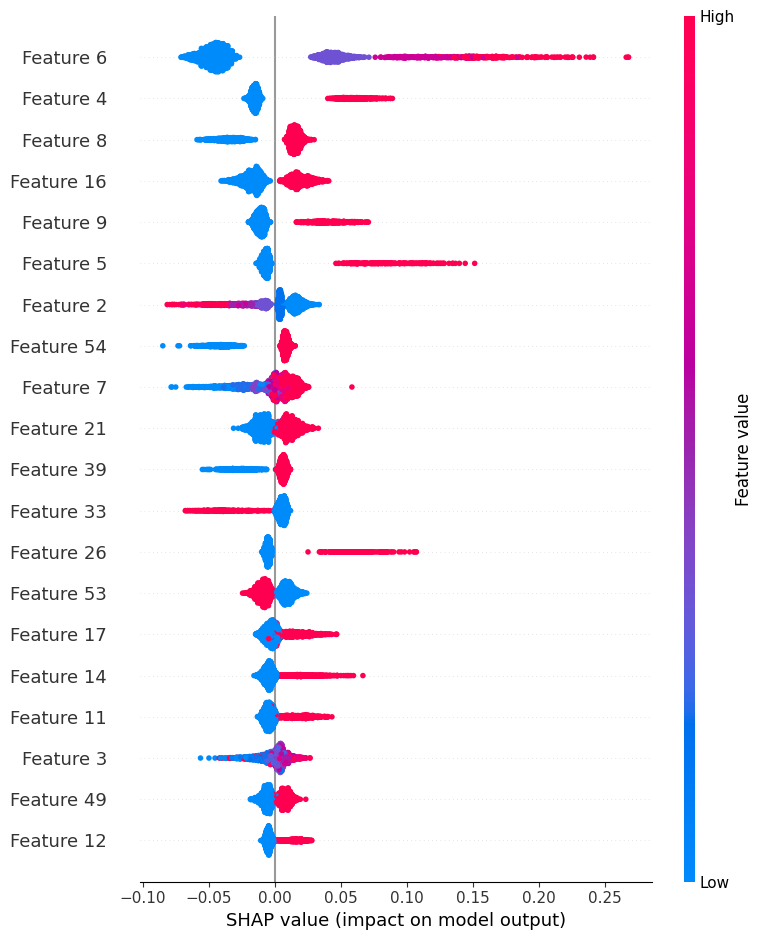

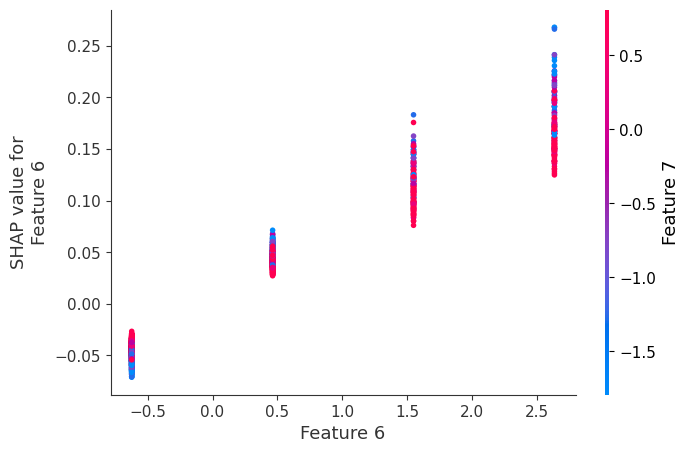

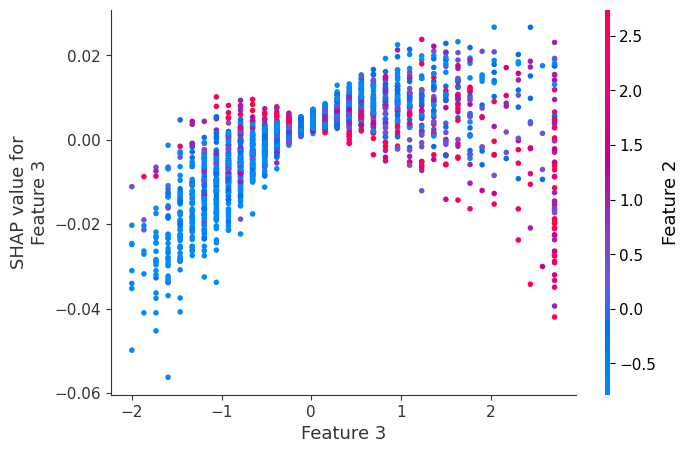

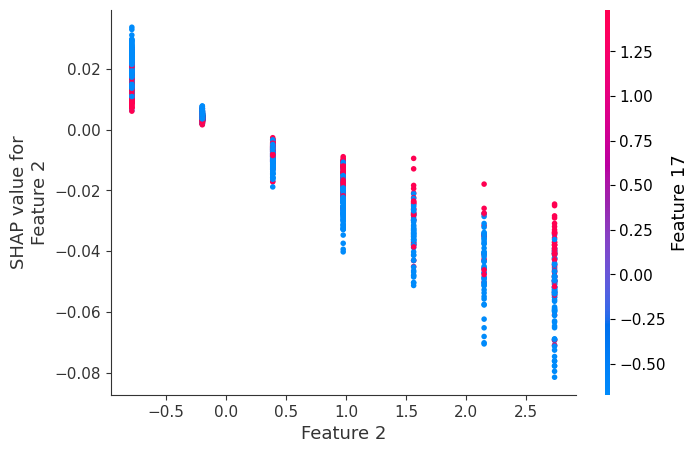

In [12]:
# Code for Shap analysis

# Rerunning a single model instance for SHAP analysis

num_epochs = 50
patience = 5
train_model_with_early_stopping(model, train_loader, test_loader, criterion, optimizer, num_epochs=num_epochs, patience=patience)
evaluate_model(model, test_loader)


def model_predict(features):
    """
    Takes input features, runs them through the trained model, and returns predictions.
    This wrapper is required because SHAP expects a callable function for the model.
    """
    model.eval()
    with torch.no_grad():
        features_tensor = torch.tensor(features, dtype=torch.float32).to(device)
        logits = model(features_tensor).squeeze().cpu().numpy()
        return torch.sigmoid(torch.tensor(logits)).numpy()  # Return probabilities


# Step 1 model_predict function declared
# Step 2: Select a background dataset for SHAP
background = X_train[:100]  # Use a small subset of the training data for efficiency

# Step 3: Initialize the SHAP Explainer
explainer = shap.Explainer(model_predict, background)

# Step 4: Generate SHAP values for the test set
shap_values = explainer(X_test)

# Compute mean absolute SHAP values for each feature
shap_mean = np.abs(shap_values.values).mean(axis=0)  # Access the .values attribute

# Create a DataFrame for easier visualization
feature_importance = pd.DataFrame({
    'Feature': feature_names,  # Ensure feature_names is correctly defined
    'Mean SHAP Value': shap_mean
}).sort_values(by='Mean SHAP Value', ascending=False)

# Adjust pandas display options
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Do not truncate line width

# Print the entire DataFrame
print(feature_importance)

# Reset options to default after printing (optional)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
# Step 5: Visualize SHAP results
# Summary plot (overall feature importance)
shap.summary_plot(shap_values, X_test)

# Dependence plot for a specific features
# List of features you are investigating dependences for
dependences = [6,3,2]
for dependence in dependences:
    shap.dependence_plot(dependence, shap_values.values, X_test)  # Replace dependence with the desired feature index

Several other models were evaluated, yielding similar accuracies, F1 scores, recall scores, and ROC scores. This indicates that the model's performance is likely more dependent on the quality and characteristics of the data rather than the neural network's structure. For details on the different neural network architectures explored, refer to the XAI branch.

Given the limited improvement observed from redesigning the model's structure, grid search was not performed, as significant gains in performance were not anticipated.

# Working with tree models

In [13]:
# Separate features and target
X = data.drop(columns=[target_column]).values  # Features as a NumPy array
y = data[target_column].values  # Target as a NumPy array

# Split data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
# Train the Random Forest classifier
rf_clf = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    max_depth=None,  # Maximum depth of trees
    random_state=42,  # For reproducibility
    n_jobs=-1,  # Use all available processors
    class_weight="balanced"  # Handle imbalanced datasets
)
rf_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Feature Importance
importances = rf_clf.feature_importances_
feature_names = data.drop(columns=[target_column]).columns
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

y_pred_proba = rf_clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC Score:", roc_auc)

print(feature_importance_df)

Accuracy: 0.6126
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.72      0.67      2731
           1       0.59      0.49      0.53      2269

    accuracy                           0.61      5000
   macro avg       0.61      0.60      0.60      5000
weighted avg       0.61      0.61      0.61      5000

ROC-AUC Score: 0.6537224453449685
                                     Feature  Importance
1                         num_lab_procedures    0.123051
3                            num_medications    0.108353
0                           time_in_hospital    0.078266
6                           number_inpatient    0.055227
2                             num_procedures    0.054882
7                           number_diagnoses    0.052989
10                             gender_Female    0.025278
21                       medical_specialty_?    0.020650
16                              payer_code_?    0.018960
38                          

In [15]:
# Train the Gradient Boosting classifier
gb_clf = GradientBoostingClassifier(
    n_estimators=100,      # Number of boosting stages
    learning_rate=0.1,     # Step size shrinkage
    max_depth=4,           # Maximum depth of each tree
    random_state=42        # For reproducibility
)
gb_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gb_clf.predict(X_test)
y_pred_proba = gb_clf.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Feature Importance
importances = gb_clf.feature_importances_
feature_names = data.drop(columns=[target_column]).columns
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

y_pred_proba = gb_clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC Score:", roc_auc)

# Set maximum rows to display to None (displays all rows)
pd.set_option('display.max_rows', None)
# print(feature_importance_df)
# Optionally, reset the display option after printing
pd.reset_option('display.max_rows')

Accuracy: 0.623
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.74      0.68      2731
           1       0.61      0.48      0.54      2269

    accuracy                           0.62      5000
   macro avg       0.62      0.61      0.61      5000
weighted avg       0.62      0.62      0.62      5000

ROC-AUC Score: 0.6659414079148391
